# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


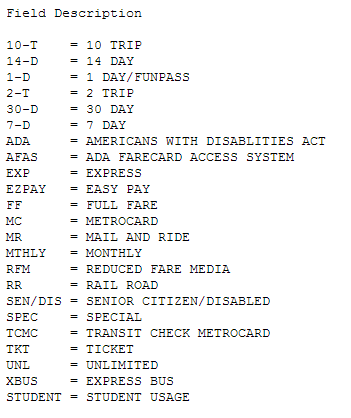

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
import csv

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [13]:
mta.shape[0]

600

You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [14]:
mta = mta.astype('float')

Converting the -1 values (no data available) to nan

In [15]:
mta[mta == -1] = np.nan

In [16]:
mta

array([[[5.6961e+04, 6.4703e+04, 6.8002e+04, ..., 3.6527e+04,
         3.3929e+04, 3.6824e+04],
        [1.7320e+03, 2.0830e+03, 2.1070e+03, ..., 1.2640e+03,
         1.1720e+03, 1.2380e+03],
        [2.0300e+02, 2.7600e+02, 2.4500e+02, ..., 1.8600e+02,
         1.6700e+02, 1.6700e+02],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [       nan,        nan,        nan, ..., 1.1210e+03,
         1.3770e+03, 7.1200e+02]],

       [[1.6210e+04, 2.0179e+04, 2.1769e+04, ...,        nan,
                nan,        nan],
        [5.0300e+02, 6.4700e+02, 6.6500e+02, ...,        nan,
                nan,        nan],
        [4.1000e+01, 4.3000e+01, 4.4000e+01, ...,        nan,
                nan,        nan],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ...,        nan,
                nan,        nan],
        [0.0

Text(0,0.5,'Number of swipes')

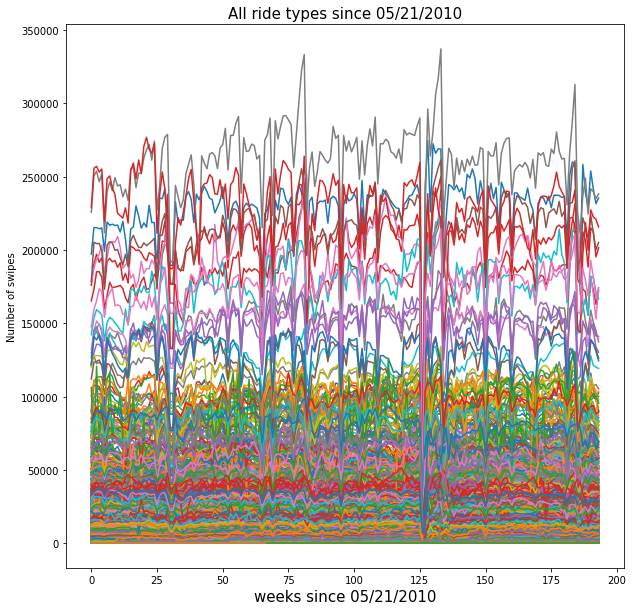

In [117]:
plt.figure(figsize=(10,10))
for i in range(mta.shape[0]):
    
    for j in range(mta.shape[1]):
        
        plt.plot(range(len(mta[i][j])), mta[i][j])
        
plt.title('All ride types since 05/21/2010', fontsize=15)
plt.xlabel('weeks since 05/21/2010', fontsize=15)
plt.ylabel('Number of swipes', fontsize=15)

Plot of the number of rides for all card for 194 weeks starting from 21 May 2010 with different colors for different card types (23). Apart from the cards of high ridership, the plots are not clearly visible because of the very high amount of data.(600 stations)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'swipes (log10)')

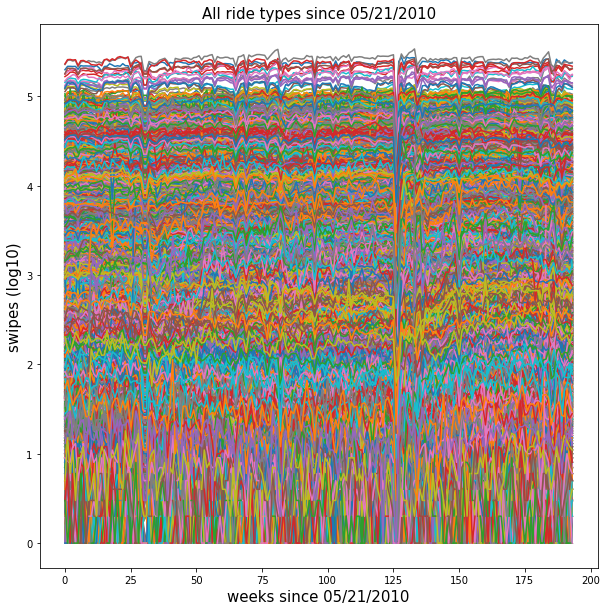

In [118]:
plt.figure(figsize=(10,10))
for i in range(mta.shape[0]):
    
    for j in range(mta.shape[1]):
        
        plt.plot(range(len(mta[i][j])), np.log10(mta[i][j]))
        
plt.title('All ride types since 05/21/2010', fontsize=15)
plt.xlabel('weeks since 05/21/2010', fontsize=15)
plt.ylabel('swipes (log10)', fontsize=15)

#### Figure 2: time series for all ride types and all stations in semi-log space

Ridership of all cards types for 600 stations in Manhattan for 194 weeks starting from 21 May 2010 taken the rides on a logarithmic scale. A significant drop can be seen for all the card types around the week of 125.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Text(0.5,1,'Number of Card swipes of all stations for different types of cards')

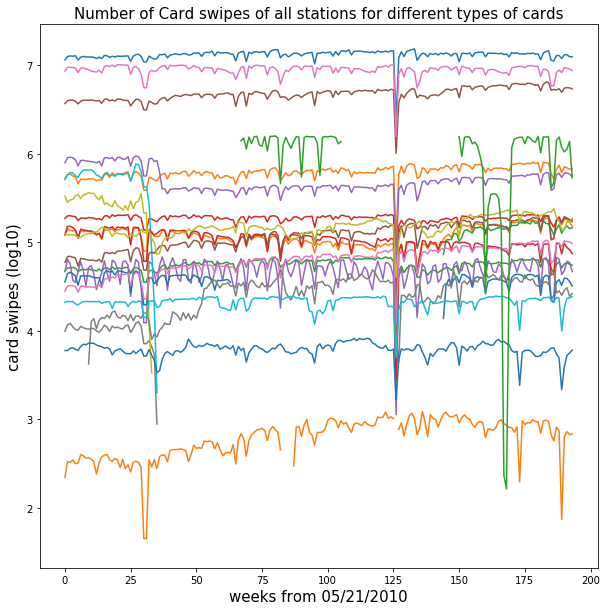

In [12]:
card_type = [i+1 for i in range(23)]
TimeSeries_card = {card_type[i]:[] for i in range(len(card_type))}


for i in range(23):
    sum = []
    
    for k in range(194):
        x = 0
        for j in range(600):
    
            x = x + np.nansum(mta[j][i][k])
        sum.append(x)
    TimeSeries_card[i+1].append(sum)
    
plt.figure(figsize=(10,10))

for i in range(23):
    plt.plot(np.log10(TimeSeries_card[i+1][0]))
    
plt.xlabel('weeks from 05/21/2010', fontsize=15)
plt.ylabel('card swipes (log10)', fontsize=15)
plt.title('Number of Card swipes of all stations for different types of cards', fontsize=15)

As can be seen from the plot, there is a significant drop in almost all time series around the week of 125. This would correspond around the the second week of December 2012. The drop could have happend possibly due to the close of several stations at the same time.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


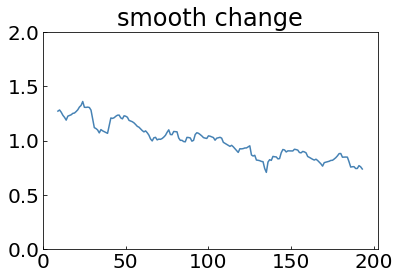

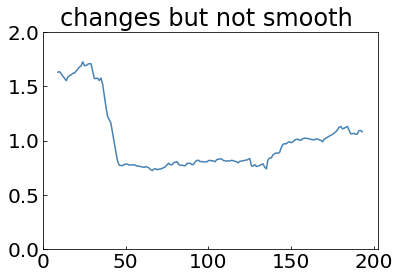

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

Making a dictionary for each card type with values as the time series of trips in the weeks

In [8]:
card_type = [i+1 for i in range(23)]
TimeSeries_card = {card_type[i]:[] for i in range(len(card_type))}


for i in range(23):
    sum = []
    
    for k in range(194):
        x = 0
        for j in range(600):
    
            x = x + np.nansum(mta[j][i][k])
        sum.append(x)
    TimeSeries_card[i+1].append(sum)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0.5,1,'Number of Card swipes of all stations for different types of cards')

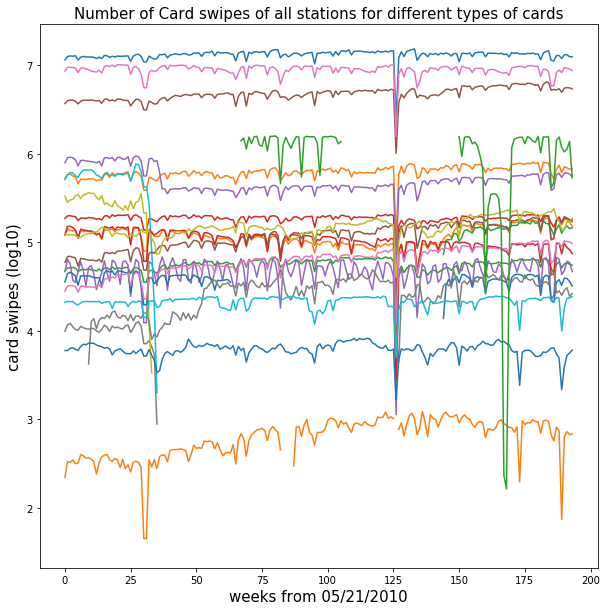

In [9]:
plt.figure(figsize=(10,10))

for i in range(23):
    plt.plot(np.log10(TimeSeries_card[i+1][0]))
    
plt.xlabel('weeks from 05/21/2010', fontsize=15)
plt.ylabel('card swipes (log10)', fontsize=15)
plt.title('Number of Card swipes of all stations for different types of cards', fontsize=15)

Plots of number of swipes for every 23 types of cards for 194 weeks from 05/21/2010 taking on a logarithmic scale. Data can be seen missing for many cards where there is no curve for an interval. We can significant drops for many card types for at least 2 times in the plot. The first drop can be seen at around week 35 where the cards of lower ridership experince very further low ridership. Another drop is at around week 125 where almost all card types see a significant drop in ridership.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

### Making a csv file with the time series of swipes for each card type (label: 0-23) for 600 stations (label: 0-599)

In [227]:
header = [i+1 for i in range(194)]
header.append('card_type')
header.append('Station')

with open('SubwayRides_TimeSeries1.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)

In [228]:
for i in range(mta.shape[0]):
    
    for j in range(mta.shape[1]):
        
        row = mta[i][j]
    
        row = np.append(row, j)
        row = np.append(row, i)
        
        with open('SubwayRides_TimeSeries1.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(row)

In [13]:
TimeSeries = pd.read_csv('SubwayRides_TimeSeries1.csv')
TimeSeries.shape

(13800, 196)

In [14]:
TimeSeries.head()

,1,2,3,4,5,6,7,8,9,10,...,187,188,189,190,191,192,193,194,card_type,Station
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0,0.0,0.0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0,1.0,0.0
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0,2.0,0.0
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0,3.0,0.0
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0,4.0,0.0


In [15]:
TimeSeries = TimeSeries.sample(frac=1).reset_index(drop=True)

Dropping the nan values and shuffling the data

In [16]:
TimeSeries.dropna(inplace=True)
TimeSeries.shape

(9174, 196)

In [7]:
label = TimeSeries['card_type']
label.shape

(9174,)

In [8]:
label[:26]

1     16.0
2     18.0
5      5.0
6     17.0
7     21.0
8      9.0
9      1.0
10    11.0
11     7.0
12    17.0
14    21.0
15     6.0
16    12.0
17     8.0
18    18.0
19     0.0
20    14.0
21     9.0
22    18.0
23    16.0
27    17.0
28    12.0
29    16.0
31     5.0
32    19.0
34    19.0
Name: card_type, dtype: float64

In [17]:
np.count_nonzero(~np.isnan(mta[0][22]))

125

### Means of all the time series of the 600 stations 

In [21]:
stationsmeans = []

for i in range(mta.shape[0]):
    len = 0
    x = 0
    for j in range(mta.shape[1]):
        x = x + np.nansum(mta[i][j])
        len = len + np.count_nonzero(~np.isnan(mta[i][j]))
        
    mean = x/len
    stationsmeans.append(mean)
    
stationsmeans

[5190.451591214702,
 897.9273868220529,
 314.94755714926043,
 826.8386373823398,
 885.7052891080233,
 968.2752129090094,
 602.4876736889287,
 560.5968175705962,
 492.1501568803227,
 8313.175257731958,
 15510.13379650381,
 15211.04280591663,
 4707.219632451815,
 8030.174137158225,
 5438.683998207082,
 1879.7097714029583,
 7988.824069923801,
 12042.090094128194,
 3876.860152398028,
 14050.275661138503,
 9349.665396683102,
 17603.2310623039,
 12521.27521290901,
 4814.91102644554,
 7234.985880770954,
 -0.9742268041237113,
 5803.677050649932,
 5736.353877185119,
 12190.71178843568,
 5131.442402510085,
 8394.971985656655,
 8250.522411474674,
 16963.963021066786,
 1950.1055580457194,
 5921.014119229046,
 1237.728821156432,
 1398.4970865082923,
 466.0627521290901,
 1223.2852980726132,
 1889.7958314657105,
 4758.045047064097,
 1079.320484087853,
 5412.828776333483,
 8396.29583146571,
 5609.410129986553,
 17174.15038099507,
 9502.621246077992,
 2530.382563872703,
 5660.64343343792,
 6565.6369341

### Standard deviations of all the time series of the 600 stations

In [22]:
stationsstd = []

for i in range(mta.shape[0]):
    arr = []
    x = 0
    for j in range(mta.shape[1]):
        x = x + np.nansum(mta[i][j])
        arr.append(x)
    
    std = np.nanstd(arr)
    stationsstd.append(std)
    
stationsstd

[4537762.314138897,
 832014.9388160649,
 254952.14905716284,
 670641.0163107514,
 759812.3541813076,
 912568.1687326261,
 499950.33146073,
 434430.95558752265,
 435576.3429013601,
 7613122.848682481,
 9372299.6741603,
 10492332.55489306,
 4254462.94862572,
 7030020.620971277,
 4005297.1144685713,
 1717353.7996602424,
 6665978.210319373,
 13731733.474503642,
 4082746.600830461,
 12558557.12712835,
 9207918.284837103,
 16716492.104347548,
 10472470.771367574,
 4378513.410513798,
 7492386.176543023,
 1253.9074383279412,
 5174332.287558192,
 5489784.485696901,
 9919715.41218591,
 4747358.823012358,
 6401833.282730495,
 8021985.664686674,
 14704384.698604975,
 2026702.143050194,
 5794567.828476309,
 1197585.8496824538,
 1522392.9940552094,
 434981.971617763,
 1178290.3705597743,
 1891054.1792585668,
 4443631.905776867,
 997643.0568138319,
 5065079.660798854,
 7698566.381179625,
 3652480.8541797632,
 13340490.746105399,
 8721210.866815008,
 2156549.707969612,
 5234053.020933004,
 6384655.909

### Building features for random forest classifier
### feature 1: mean(time series)/mean(all time series for that station)
### feature 2: std(time series)/std(all time series for that station)

In [23]:
feature1 = []
feature2 = []

for i in range(TimeSeries.shape[0]):
    
    value = np.array(TimeSeries.iloc[:, 0:194].mean(axis=1))[i]/stationsmeans[int(np.array(TimeSeries['Station'])[i])]
    
    feature1.append(value)
    
for i in range(TimeSeries.shape[0]):
    
    value = np.array(TimeSeries.iloc[:, 0:194].std(axis=1))[i]/stationsstd[int(np.array(TimeSeries['Station'])[i])]
    
    feature2.append(value)

In [24]:
TimeSeries['feature1'] = feature1
TimeSeries['feature2'] = feature2

In [25]:
TimeSeries.head()

,1,2,3,4,5,6,7,8,9,10,...,189,190,191,192,193,194,card_type,Station,feature1,feature2
1,97.0,135.0,97.0,94.0,116.0,122.0,92.0,91.0,119.0,90.0,...,249.0,209.0,155.0,202.0,205.0,229.0,18.0,205.0,0.049522,0.000018
4,1322.0,1708.0,1714.0,1675.0,1623.0,1235.0,1629.0,1617.0,1550.0,1468.0,...,1331.0,930.0,1339.0,1118.0,1045.0,1002.0,13.0,43.0,0.156307,0.000035
10,174.0,196.0,196.0,170.0,179.0,128.0,116.0,124.0,139.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0,0.095450,0.000264
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,139.0,0.000000,0.000000
12,370.0,333.0,340.0,325.0,335.0,331.0,331.0,317.0,318.0,319.0,...,427.0,354.0,382.0,358.0,363.0,337.0,3.0,370.0,0.263794,0.000054


### Normalized time series

In [43]:
TimeSeries_norm = (TimeSeries.iloc[:, 0:194] - TimeSeries.iloc[:, 0:194].mean())/TimeSeries.iloc[:, 0:194].std()
TimeSeries_norm['card_type'] = TimeSeries['card_type'].values
TimeSeries_norm.head()

,1,2,3,4,5,6,7,8,9,10,...,186,187,188,189,190,191,192,193,194,card_type
1,-0.250385,-0.246799,-0.248950,-0.249721,-0.246488,-0.248667,-0.249191,-0.248433,-0.246758,-0.249875,...,-0.219115,-0.214841,-0.234666,-0.240003,-0.239423,-0.245084,-0.245595,-0.245990,-0.241926,18.0
4,-0.135745,-0.112907,-0.113503,-0.115865,-0.118681,-0.141681,-0.116058,-0.118862,-0.123413,-0.129923,...,-0.196650,-0.197788,-0.150884,-0.149636,-0.174597,-0.150269,-0.171025,-0.174704,-0.175475,13.0
10,-0.243179,-0.241607,-0.240657,-0.243286,-0.241145,-0.248090,-0.247112,-0.245631,-0.245034,-0.243086,...,-0.246905,-0.251412,-0.257076,-0.260799,-0.258214,-0.257496,-0.262040,-0.263387,-0.261612,9.0
11,-0.259462,-0.258290,-0.257075,-0.257680,-0.256326,-0.260394,-0.257160,-0.256160,-0.257015,-0.257710,...,-0.246905,-0.251412,-0.257076,-0.260799,-0.258214,-0.257496,-0.262040,-0.263387,-0.261612,17.0
12,-0.224836,-0.229946,-0.228595,-0.230163,-0.227915,-0.228577,-0.228489,-0.229244,-0.229606,-0.229941,...,-0.210884,-0.218883,-0.224905,-0.225137,-0.226386,-0.226906,-0.232896,-0.232581,-0.232642,3.0


In [44]:
TimeSeries_norm.dropna(inplace=True)

In [48]:
TimeSeries_norm.shape[0]

9174

### Creating features 3 and 4 as intercept and slope of ols line respectively


In [72]:
feature3 = []
feature4 = []

for i in range(TimeSeries_norm.shape[0]):
    
    X = np.matrix(TimeSeries_norm.iloc[i, 0:194])
    y = np.matrix(TimeSeries_norm.iloc[i, 194]).T
    model = sm.OLS(y, X).fit()
    feature3.append(model.params[0])
    feature4.append(model.params[1])

In [73]:
TimeSeries['feature3'] = feature3
TimeSeries['feature4'] = feature4

In [74]:
TimeSeries.head()

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,card_type,Station,feature1,feature2,feature3,feature4
1,97.0,135.0,97.0,94.0,116.0,122.0,92.0,91.0,119.0,90.0,...,155.0,202.0,205.0,229.0,18.0,205.0,0.049522,0.000018,-0.411327,-0.405437
4,1322.0,1708.0,1714.0,1675.0,1623.0,1235.0,1629.0,1617.0,1550.0,1468.0,...,1339.0,1118.0,1045.0,1002.0,13.0,43.0,0.156307,0.000035,-0.429800,-0.357490
10,174.0,196.0,196.0,170.0,179.0,128.0,116.0,124.0,139.0,168.0,...,0.0,0.0,0.0,0.0,9.0,2.0,0.095450,0.000264,-0.181740,-0.180566
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17.0,139.0,0.000000,0.000000,-0.358814,-0.357193
12,370.0,333.0,340.0,325.0,335.0,331.0,331.0,317.0,318.0,319.0,...,382.0,358.0,363.0,337.0,3.0,370.0,0.263794,0.000054,-0.070103,-0.071696


you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


You can use the sklearn train_test_split() function to create your training and test dataset. 

In [77]:
TimeSeries = TimeSeries[['card_type', 'feature1', 'feature2', 'feature3', 'feature4']]
TimeSeries.reset_index(drop=True, inplace=True)
TimeSeries.head()

,card_type,feature1,feature2,feature3,feature4
0,18.0,0.049522,0.000018,-0.411327,-0.405437
1,13.0,0.156307,0.000035,-0.429800,-0.357490
2,9.0,0.095450,0.000264,-0.181740,-0.180566
3,17.0,0.000000,0.000000,-0.358814,-0.357193
4,3.0,0.263794,0.000054,-0.070103,-0.071696


In [83]:
X = np.matrix(TimeSeries.iloc[:, 1:5])
y = np.matrix(TimeSeries['card_type']).T

### Train test split with 67-33

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [85]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146, 1), (3028, 1))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [86]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

Initializing default random forest classifier

In [100]:
clf = rfc()

In [101]:
clf.fit(X, y)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [102]:
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

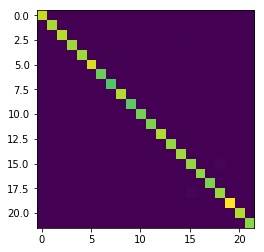

In [103]:
imshow(confusion_matrix(y_test, y_pred))

Confusion matrix showing the predicted values from the test set after training the classifier. It can be seen the classifier did a good job in prediction of the values as there are very few false positive and false negative predictions in the matrix

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [104]:
X = np.matrix(TimeSeries_norm.iloc[:, 0:194])
y = np.matrix(TimeSeries_norm['card_type']).T
X = sm.add_constant(X)

In [105]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=True)

In [106]:
clf = rfc()
clf.fit(X, y)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

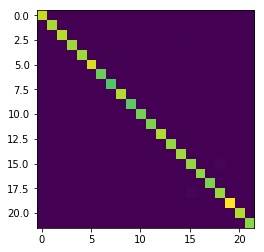

In [107]:
imshow(confusion_matrix(y_test, y_pred))

Confusion matrix showing the predicted values from the test set after training the classifier. It can be seen the classifier did a good job in prediction of the values as there are very few false positive and false negative predictions in the matrix

In [108]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       1.00      1.00      1.00       147
        14d       1.00      1.00      1.00       141
         1d       1.00      1.00      1.00       144
         2t       1.00      0.99      1.00       139
        30d       1.00      0.99      1.00       139
         7d       0.99      0.99      0.99       152
        ada       0.99      0.99      0.99       126
       afas       1.00      1.00      1.00       118
        exp       0.99      1.00      0.99       143
         ez       1.00      0.99      1.00       122
         ff       1.00      1.00      1.00       128
         mc       1.00      1.00      1.00       130
         mr       0.99      1.00      1.00       143
      month       1.00      1.00      1.00       136
        rfm       0.99      0.99      0.99       139
         rr       0.99      0.99      0.99       138
        sen       0.99      1.00      1.00       135
       spec       1.00      1.00      1.00   

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))
